### Connect to Drive

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd "/gdrive/My Drive/CNN-Architectures/"

### Import libraries

In [ ]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [ ]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.13.0


In [ ]:
# Import other libraries
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns

### Load, inspect and process data

In [ ]:
# Load CIFAR-100 dataset and split into training, validation and test sets
(X_train, y_train), (X_test, y_test) = tfk.datasets.cifar100.load_data()
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=len(X_test), random_state=seed, stratify=y_train)

# Print shapes of the datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

169001437/169001437 [==============================] - 10s 0us/step
X_train shape: (40000, 32, 32, 3), y_train shape: (40000, 1)
X_val shape: (10000, 32, 32, 3), y_val shape: (10000, 1)
X_test shape: (10000, 32, 32, 3), y_test shape: (10000, 1)


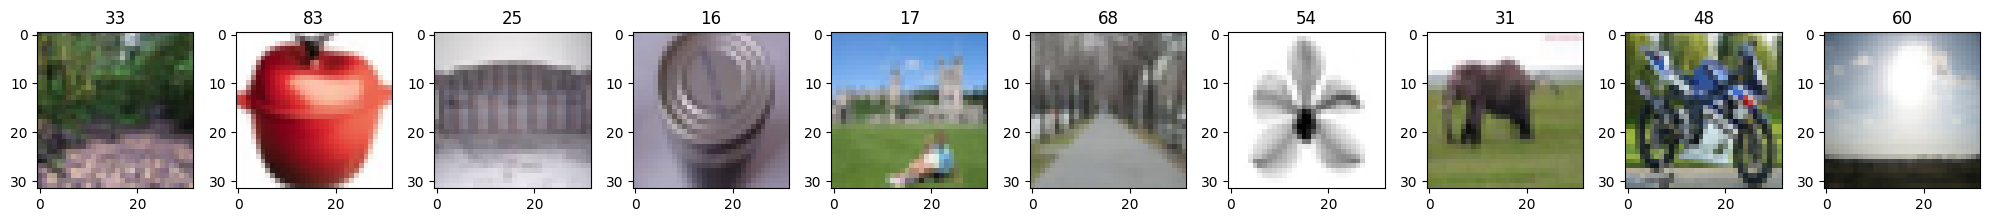

In [ ]:
# Display a sample of images from the training-validation dataset
num_img = 10
fig, axes = plt.subplots(1, num_img, figsize=(20, 20))

# Iterate through the selected number of images
for i in range(num_img):
    idx = np.random.randint(len(X_train))
    ax = axes[i % num_img]
    ax.imshow(X_train[idx])
    ax.set_title('{}'.format(y_train[idx][0]))

# Adjust layout and display the images
plt.tight_layout()
plt.show()

In [ ]:
# Normalize data to the range [0, 1]
X_train = X_train.astype("float32")/255.
X_val = X_val.astype("float32")/255.
X_test = X_test.astype("float32")/255.

In [ ]:
# Display the count of occurrences of target classes in the training-validation dataset
print('Counting occurrences of target classes:')
print(pd.DataFrame(y_train, columns=['class'])['class'].value_counts())

Counting occurrences of target classes:
4     400
2     400
84    400
15    400
37    400
     ... 
62    400
41    400
12    400
0     400
93    400
Name: class, Length: 100, dtype: int64


In [ ]:
# Convert labels to categorical format using one-hot encoding
y_train = tfk.utils.to_categorical(y_train,len(np.unique(y_train)))
y_val = tfk.utils.to_categorical(y_val,len(np.unique(y_val)))
y_test = tfk.utils.to_categorical(y_test,len(np.unique(y_test)))

In [ ]:
# Define batch size, number of epochs, learning rate, input shape, and output shape
batch_size = 256
epochs = 1000
learning_rate = 1e-4
input_shape = X_train.shape[1:]
output_shape = y_train.shape[-1]

# Print batch size, epochs, learning rate, input shape, and output shape
print(f"Batch Size: {batch_size}, Epochs: {epochs}, Learning Rate: {learning_rate}")
print(f"Input Shape: {input_shape}, Output Shape: {output_shape}")

Batch Size: 256, Epochs: 1000, Learning Rate: 0.0001
Input Shape: (32, 32, 3), Output Shape: 100


In [ ]:
# Define two callback functions for early stopping and learning rate reduction
callbacks=[
    tfk.callbacks.EarlyStopping(monitor='val_accuracy', patience=25, restore_best_weights=True, mode='max'),
    tfk.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.1, patience=20, min_lr=1e-5, mode='max')
]

# Print the defined callbacks
print("Callbacks:")
for callback in callbacks:
    print(callback)

Callbacks:


### VGG-like architecture

In [ ]:
# Define a convolutional block function with multiple parameters
def conv_block(x, filters, kernel_size, padding='same', downsample=True, activation='relu', stack=2, name=''):

    # If downsample is True, apply max-pooling
    if downsample:
        x = tfkl.MaxPooling2D(name='MaxPool_' + name)(x)

    # Apply a stack of convolutional layers with specified filters, kernel size, and activation
    for s in range(stack):
        x = tfkl.Conv2D(filters=filters, kernel_size=kernel_size, padding=padding, name='Conv_' + name + str(s+1))(x)
        x = tfkl.Activation(activation, name='Activation_' + name + str(s+1))(x)

    return x

In [ ]:
# Define a function to build a VGG18-like model
def build_model(input_shape=input_shape, output_shape=output_shape, learning_rate=learning_rate, seed=seed):

    # Input layer
    input_layer = tfkl.Input(shape=input_shape, name='Input_Layer')

    # Define a preprocessing Sequential model with random flip, zero padding, and random crop
    preprocessing = tfk.Sequential([
        tfkl.RandomFlip('horizontal', name='RandomFlip_horizontal'),
        tfkl.ZeroPadding2D((2, 2), name='ZeroPadding_2x2'),
        tfkl.RandomCrop(input_shape[0], input_shape[1], name='RandomCrop')
    ], name='Preprocessing')

    # Apply preprocessing to input layer
    x0 = preprocessing(input_layer)

    # Initial convolution and activation
    x0 = tfkl.Conv2D(filters=64, kernel_size=3, padding='same', name='Conv0')(x0)
    x0 = tfkl.Activation('relu', name='ReLU0')(x0)

    # Create convolutional blocks
    x1 = conv_block(x=x0, filters=64, kernel_size=3, downsample=False, stack=2, name='1')
    x1 = conv_block(x=x1, filters=64, kernel_size=3, downsample=False, stack=2, name='2')

    x2 = conv_block(x=x1, filters=128, kernel_size=3, downsample=True, stack=2, name='3')
    x2 = conv_block(x=x2, filters=128, kernel_size=3, downsample=False, stack=2, name='4')

    x3 = conv_block(x=x2, filters=256, kernel_size=3, downsample=True, stack=2, name='5')
    x3 = conv_block(x=x3, filters=256, kernel_size=3, downsample=False, stack=2, name='6')

    x4 = conv_block(x=x3, filters=512, kernel_size=3, downsample=True, stack=2, name='7')
    x4 = conv_block(x=x4, filters=512, kernel_size=3, downsample=False, stack=2, name='8')

    # Global Average Pooling and classifier
    x = tfkl.GlobalAveragePooling2D(name='GlobalAveragePooling')(x4)
    x = tfkl.Dense(output_shape, name='Dense')(x)
    output_activation = tfkl.Activation('softmax', name='Softmax')(x)

    # Create the model
    model = tfk.Model(inputs=input_layer, outputs=output_activation, name='VGG18')

    # Define optimizer, loss, and metrics
    # AdamW is an Adam optimizer which applies weight_decay to network layers,
    # i.e it's another way to apply l2 regularization to the whole network
    optimizer = tfk.optimizers.AdamW(learning_rate, weight_decay=5e-4)
    loss = tfk.losses.CategoricalCrossentropy()
    metrics = ['accuracy']

    # Compile the model
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model

Model: "VGG18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_Layer (InputLayer)    [(None, 32, 32, 3)]       0         
                                                                 
 Preprocessing (Sequential)  (None, 32, 32, 3)         0         
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| RandomFlip_horizontal (Ra  (None, 32, 32, 3)         0        |
| ndomFlip)                                                     |
|                                                               |
| ZeroPadding_2x2 (ZeroPadd  (None, 36, 36, 3)         0        |
| ing2D)                                                        |
|                                                               |
| RandomCrop (RandomCrop)    (None, 32, 32, 3)         0        |
¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯
 Conv0 (Conv2D)              (None, 32, 32, 64)        1792  

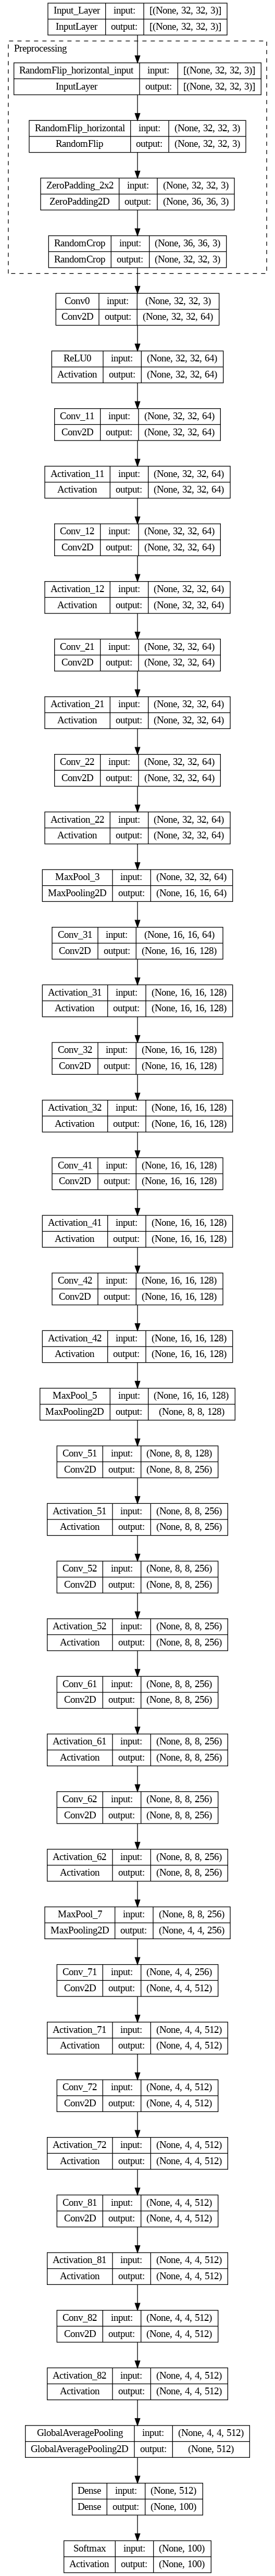

In [ ]:
baseline_model = build_model()
baseline_model.summary(expand_nested=True)
tfk.utils.plot_model(baseline_model, expand_nested=True, show_shapes=True)

In [ ]:
baseline_history = baseline_model.fit(
    X_train,
    y_train,
    validation_data=(X_val,y_val),
    epochs=epochs,
    batch_size=batch_size,
    verbose=1,
    callbacks=callbacks
).history

Epoch 1/1000
157/157 [==============================] - 18s 82ms/step - loss: 4.5344 - accuracy: 0.0141 - val_loss: 4.3886 - val_accuracy: 0.0197 - lr: 1.0000e-04
Epoch 2/1000
157/157 [==============================] - 12s 73ms/step - loss: 4.2588 - accuracy: 0.0299 - val_loss: 4.2000 - val_accuracy: 0.0354 - lr: 1.0000e-04
Epoch 3/1000
157/157 [==============================] - 12s 74ms/step - loss: 4.1195 - accuracy: 0.0399 - val_loss: 4.0959 - val_accuracy: 0.0489 - lr: 1.0000e-04
Epoch 4/1000
157/157 [==============================] - 12s 76ms/step - loss: 3.9947 - accuracy: 0.0599 - val_loss: 3.9812 - val_accuracy: 0.0682 - lr: 1.0000e-04
Epoch 5/1000
157/157 [==============================] - 12s 74ms/step - loss: 3.8780 - accuracy: 0.0800 - val_loss: 3.8428 - val_accuracy: 0.0879 - lr: 1.0000e-04
Epoch 6/1000
157/157 [==============================] - 11s 73ms/step - loss: 3.7754 - accuracy: 0.0989 - val_loss: 3.8035 - val_accuracy: 0.0987 - lr: 1.0000e-04
Epoch 7/1000
157/157 [

157/157 [==============================] - 12s 75ms/step - loss: 1.2445 - accuracy: 0.6313 - val_loss: 2.5465 - val_accuracy: 0.3992 - lr: 1.0000e-04
Epoch 52/1000
157/157 [==============================] - 12s 75ms/step - loss: 1.2081 - accuracy: 0.6396 - val_loss: 2.6630 - val_accuracy: 0.3860 - lr: 1.0000e-04
Epoch 53/1000
157/157 [==============================] - 12s 76ms/step - loss: 1.1782 - accuracy: 0.6494 - val_loss: 2.5750 - val_accuracy: 0.4006 - lr: 1.0000e-04
Epoch 54/1000
157/157 [==============================] - 12s 74ms/step - loss: 1.1027 - accuracy: 0.6697 - val_loss: 2.7253 - val_accuracy: 0.3881 - lr: 1.0000e-04
Epoch 55/1000
157/157 [==============================] - 12s 73ms/step - loss: 1.0858 - accuracy: 0.6728 - val_loss: 2.7235 - val_accuracy: 0.3802 - lr: 1.0000e-04
Epoch 56/1000
157/157 [==============================] - 12s 75ms/step - loss: 1.0434 - accuracy: 0.6817 - val_loss: 2.6634 - val_accuracy: 0.3889 - lr: 1.0000e-04
Epoch 57/1000
157/157 [=======

### VGG-like architecture with Batch Normalization

---



In [ ]:
# Define a convolutional block with batch normalization option
def conv_bn_block(x, filters, kernel_size, padding='same', downsample=True, activation='relu', stack=2, batch_norm=True, name=''):

    # If downsample is True, apply max-pooling
    if downsample:
        x = tfkl.MaxPooling2D(name='MaxPool_' + name)(x)

    # Apply a stack of convolutional layers with optional batch normalization and specified activation
    for s in range(stack):
        x = tfkl.Conv2D(filters=filters, kernel_size=kernel_size, padding=padding, name='Conv_' + name + str(s+1))(x)
        if batch_norm:
            x = tfkl.BatchNormalization(name='BatchNorm_' + name + str(s+1))(x)
        x = tfkl.Activation(activation, name='Activation_' + name + str(s+1))(x)

    return x

In [ ]:
# Define a function to build a VGG18-like model with batch normalization
def build_bn_model(input_shape=input_shape, output_shape=output_shape, learning_rate=1e-4, seed=seed):

    # Input layer
    input_layer = tfkl.Input(shape=input_shape, name='Input_Layer')

    # Define a preprocessing Sequential model with random flip, zero padding, and random crop
    preprocessing = tfk.Sequential([
        tfkl.RandomFlip('horizontal', name='RandomFlip_horizontal'),
        tfkl.ZeroPadding2D((2, 2), name='ZeroPadding_2x2'),
        tfkl.RandomCrop(input_shape[0], input_shape[1], name='RandomCrop')
    ], name='Preprocessing')

    # Apply preprocessing to the input layer
    x0 = preprocessing(input_layer)

    # Initial convolution with batch normalization and activation
    x0 = tfkl.Conv2D(filters=64, kernel_size=3, padding='same', name='Conv0')(x0)
    x0 = tfkl.BatchNormalization(name='BatchNorm0')(x0)
    x0 = tfkl.Activation('relu', name='ReLU0')(x0)

    # Create convolutional blocks with batch normalization
    x1 = conv_bn_block(x=x0, filters=64, kernel_size=3, downsample=False, stack=2, batch_norm=True, name='1')
    x1 = conv_bn_block(x=x1, filters=64, kernel_size=3, downsample=False, stack=2, batch_norm=True, name='2')

    x2 = conv_bn_block(x=x1, filters=128, kernel_size=3, downsample=True, stack=2, batch_norm=True, name='3')
    x2 = conv_bn_block(x=x2, filters=128, kernel_size=3, downsample=False, stack=2, batch_norm=True, name='4')

    x3 = conv_bn_block(x=x2, filters=256, kernel_size=3, downsample=True, stack=2, batch_norm=True, name='5')
    x3 = conv_bn_block(x=x3, filters=256, kernel_size=3, downsample=False, stack=2, batch_norm=True, name='6')

    x4 = conv_bn_block(x=x3, filters=512, kernel_size=3, downsample=True, stack=2, batch_norm=True, name='7')
    x4 = conv_bn_block(x=x4, filters=512, kernel_size=3, downsample=False, stack=2, batch_norm=True, name='8')

    # Global Average Pooling and classifier
    x = tfkl.GlobalAveragePooling2D(name='GlobalAveragePooling')(x4)
    x = tfkl.Dense(output_shape, name='Dense')(x)
    output_activation = tfkl.Activation('softmax', name='Softmax')(x)

    # Create the model
    model = tfk.Model(inputs=input_layer, outputs=output_activation, name='VGG18_BN')

    # Define optimizer, loss, and metrics
    # AdamW is an Adam optimizer which applies weight_decay to network layers,
    # i.e it's another way to apply l2 regularization to the whole network
    optimizer = tfk.optimizers.AdamW(learning_rate, weight_decay=5e-4)
    loss = tfk.losses.CategoricalCrossentropy()
    metrics = ['accuracy']

    # Compile the model
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model

Model: "VGG18_BN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_Layer (InputLayer)    [(None, 32, 32, 3)]       0         
                                                                 
 Preprocessing (Sequential)  (None, 32, 32, 3)         0         
                                                                 
 Conv0 (Conv2D)              (None, 32, 32, 64)        1792      
                                                                 
 BatchNorm0 (BatchNormaliza  (None, 32, 32, 64)        256       
 tion)                                                           
                                                                 
 ReLU0 (Activation)          (None, 32, 32, 64)        0         
                                                                 
 Conv_11 (Conv2D)            (None, 32, 32, 64)        36928     
                                                          

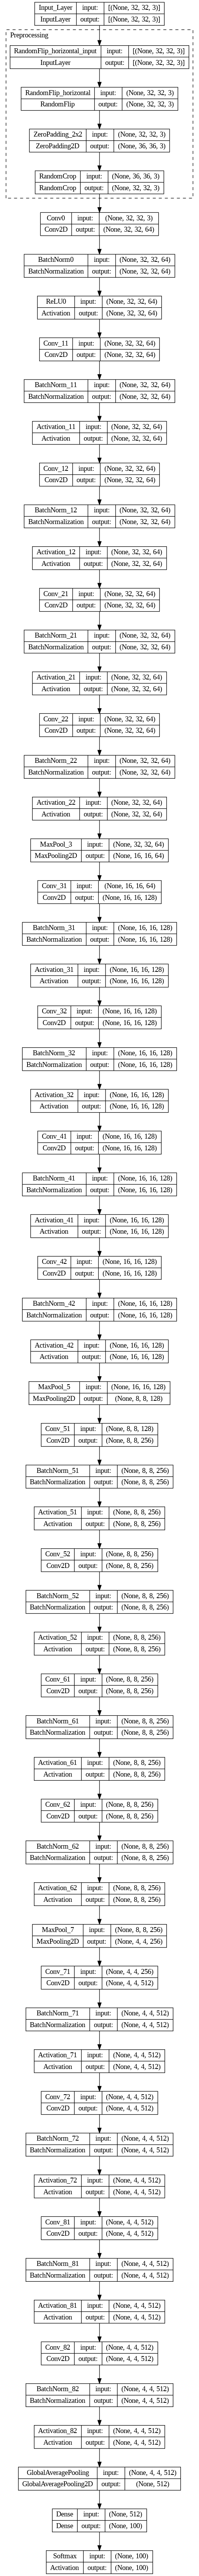

In [ ]:
bn_model = build_bn_model()
bn_model.summary()
tfk.utils.plot_model(bn_model, expand_nested=True, show_shapes=True)

In [ ]:
bn_history = bn_model.fit(
    X_train,
    y_train,
    validation_data=(X_val,y_val),
    epochs=epochs,
    batch_size=batch_size,
    verbose=1,
    callbacks=callbacks
).history

Epoch 1/1000
157/157 [==============================] - 25s 98ms/step - loss: 3.8294 - accuracy: 0.1264 - val_loss: 4.9905 - val_accuracy: 0.0100 - lr: 1.0000e-04
Epoch 2/1000
157/157 [==============================] - 14s 91ms/step - loss: 3.1456 - accuracy: 0.2322 - val_loss: 4.8187 - val_accuracy: 0.0284 - lr: 1.0000e-04
Epoch 3/1000
157/157 [==============================] - 15s 93ms/step - loss: 2.8071 - accuracy: 0.2958 - val_loss: 4.0195 - val_accuracy: 0.1183 - lr: 1.0000e-04
Epoch 4/1000
157/157 [==============================] - 14s 92ms/step - loss: 2.5340 - accuracy: 0.3498 - val_loss: 3.0585 - val_accuracy: 0.2578 - lr: 1.0000e-04
Epoch 5/1000
157/157 [==============================] - 14s 91ms/step - loss: 2.3127 - accuracy: 0.3983 - val_loss: 2.8670 - val_accuracy: 0.2889 - lr: 1.0000e-04
Epoch 6/1000
157/157 [==============================] - 14s 91ms/step - loss: 2.1275 - accuracy: 0.4396 - val_loss: 2.9568 - val_accuracy: 0.2746 - lr: 1.0000e-04
Epoch 7/1000
157/157 [

157/157 [==============================] - 15s 94ms/step - loss: 0.0956 - accuracy: 0.9745 - val_loss: 2.8998 - val_accuracy: 0.4655 - lr: 1.0000e-04
Epoch 52/1000
157/157 [==============================] - 15s 94ms/step - loss: 0.0974 - accuracy: 0.9728 - val_loss: 2.6735 - val_accuracy: 0.4849 - lr: 1.0000e-04
Epoch 53/1000
157/157 [==============================] - 14s 91ms/step - loss: 0.0882 - accuracy: 0.9756 - val_loss: 2.8151 - val_accuracy: 0.4702 - lr: 1.0000e-04
Epoch 54/1000
157/157 [==============================] - 14s 90ms/step - loss: 0.0892 - accuracy: 0.9755 - val_loss: 2.7969 - val_accuracy: 0.4779 - lr: 1.0000e-04
Epoch 55/1000
157/157 [==============================] - 14s 90ms/step - loss: 0.0869 - accuracy: 0.9766 - val_loss: 2.9276 - val_accuracy: 0.4649 - lr: 1.0000e-04
Epoch 56/1000
157/157 [==============================] - 14s 92ms/step - loss: 0.0798 - accuracy: 0.9791 - val_loss: 2.8317 - val_accuracy: 0.4813 - lr: 1.0000e-04
Epoch 57/1000
157/157 [=======

157/157 [==============================] - 14s 92ms/step - loss: 0.0043 - accuracy: 0.9995 - val_loss: 2.5678 - val_accuracy: 0.5402 - lr: 1.0000e-05
Epoch 102/1000
157/157 [==============================] - 14s 90ms/step - loss: 0.0039 - accuracy: 0.9996 - val_loss: 2.5031 - val_accuracy: 0.5475 - lr: 1.0000e-05
Epoch 103/1000
157/157 [==============================] - 14s 92ms/step - loss: 0.0039 - accuracy: 0.9995 - val_loss: 2.5388 - val_accuracy: 0.5480 - lr: 1.0000e-05
Epoch 104/1000
157/157 [==============================] - 14s 92ms/step - loss: 0.0038 - accuracy: 0.9997 - val_loss: 2.5380 - val_accuracy: 0.5430 - lr: 1.0000e-05
Epoch 105/1000
157/157 [==============================] - 15s 93ms/step - loss: 0.0039 - accuracy: 0.9995 - val_loss: 2.5275 - val_accuracy: 0.5437 - lr: 1.0000e-05
Epoch 106/1000
157/157 [==============================] - 14s 90ms/step - loss: 0.0037 - accuracy: 0.9995 - val_loss: 2.5503 - val_accuracy: 0.5453 - lr: 1.0000e-05
Epoch 107/1000
157/157 [=

### VGG-like architecture with Batch Normalization and Skip Connections (Residual VGG)

In [ ]:
# Define a residual convolutional block with optional batch normalization
def conv_residual_block(x, filters, kernel_size, padding='same', downsample=True, activation='relu', stack=2, batch_norm=True, name=''):

    # If downsample is True, apply max-pooling
    if downsample:
        x = tfkl.MaxPooling2D(name='MaxPool_' + name)(x)

    # Create a copy of the input for the residual connection
    x_ = x

    # Apply a stack of convolutional layers to the copy
    for s in range(stack):
        x_ = tfkl.Conv2D(filters=filters, kernel_size=kernel_size, padding=padding, name='Conv_' + name + str(s+1))(x_)
        if batch_norm:
            x_ = tfkl.BatchNormalization(name='BatchNorm_' + name + str(s+1))(x_)
        x_ = tfkl.Activation(activation, name='Activation_' + name + str(s+1))(x_)

    # If downsample is True, apply a 1x1 convolution to match the number of filters
    if downsample:
        x = tfkl.Conv2D(filters=filters, kernel_size=1, padding=padding, name='Conv_' + name + 'skip')(x)

    # Add the original and the processed copy to create the residual connection
    x = tfkl.Add(name='Add_' + name)([x_, x])

    return x

In [ ]:
# Define a function to build a VGG18-like model with residual blocks
def build_model_residual(input_shape=input_shape, output_shape=output_shape, learning_rate=1e-4, seed=seed):

    # Input layer
    input_layer = tfkl.Input(shape=input_shape, name='Input_Layer')

    # Define a preprocessing Sequential model with random flip, zero padding, and random crop
    preprocessing = tfk.Sequential([
        tfkl.RandomFlip('horizontal', name='RandomFlip_horizontal'),
        tfkl.ZeroPadding2D((2, 2), name='ZeroPadding_2x2'),
        tfkl.RandomCrop(input_shape[0], input_shape[1], name='RandomCrop')
    ], name='Preprocessing')

    # Apply preprocessing to the input layer
    x0 = preprocessing(input_layer)

    # Initial convolution with batch normalization and activation
    x0 = tfkl.Conv2D(filters=64, kernel_size=3, padding='same', name='Conv0')(x0)
    x0 = tfkl.BatchNormalization(name='BatchNorm0')(x0)
    x0 = tfkl.Activation('relu', name='ReLU0')(x0)

    # Create residual blocks
    x1 = conv_residual_block(x=x0, filters=64, kernel_size=3, downsample=False, stack=2, name='1')
    x1 = conv_residual_block(x=x1, filters=64, kernel_size=3, downsample=False, stack=2, name='2')

    x2 = conv_residual_block(x=x1, filters=128, kernel_size=3, downsample=True, stack=2, name='3')
    x2 = conv_residual_block(x=x2, filters=128, kernel_size=3, downsample=False, stack=2, name='4')

    x3 = conv_residual_block(x=x2, filters=256, kernel_size=3, downsample=True, stack=2, name='5')
    x3 = conv_residual_block(x=x3, filters=256, kernel_size=3, downsample=False, stack=2, name='6')

    x4 = conv_residual_block(x=x3, filters=512, kernel_size=3, downsample=True, stack=2, name='7')
    x4 = conv_residual_block(x=x4, filters=512, kernel_size=3, downsample=False, stack=2, name='8')

    # Global Average Pooling and classifier
    x = tfkl.GlobalAveragePooling2D(name='GlobalAveragePooling')(x4)
    x = tfkl.Dense(output_shape, name='Dense')(x)
    output_activation = tfkl.Activation('softmax', name='Softmax')(x)

    # Create the model
    model = tfk.Model(inputs=input_layer, outputs=output_activation, name='VGG18_Residual')

    # Define optimizer, loss, and metrics
    # AdamW is an Adam optimizer which applies weight_decay to network layers,
    # i.e it's another way to apply l2 regularization to the whole network
    optimizer = tfk.optimizers.AdamW(learning_rate, weight_decay=5e-4)
    loss = tfk.losses.CategoricalCrossentropy()
    metrics = ['accuracy']

    # Compile the model
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model

Model: "VGG18_BN"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_layer (InputLayer)    [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 preprocessing (Sequential)  (None, 32, 32, 3)            0         ['input_layer[0][0]']         
                                                                                                  
 conv0 (Conv2D)              (None, 32, 32, 64)           1792      ['preprocessing[0][0]']       
                                                                                                  
 bn0 (BatchNormalization)    (None, 32, 32, 64)           256       ['conv0[0][0]']               
                                                                                           

 relu51 (Activation)         (None, 8, 8, 256)            0         ['bn51[0][0]']                
                                                                                                  
 conv52 (Conv2D)             (None, 8, 8, 256)            590080    ['relu51[0][0]']              
                                                                                                  
 bn52 (BatchNormalization)   (None, 8, 8, 256)            1024      ['conv52[0][0]']              
                                                                                                  
 relu52 (Activation)         (None, 8, 8, 256)            0         ['bn52[0][0]']                
                                                                                                  
 conv5skip (Conv2D)          (None, 8, 8, 256)            33024     ['mp5[0][0]']                 
                                                                                                  
 add5 (Add

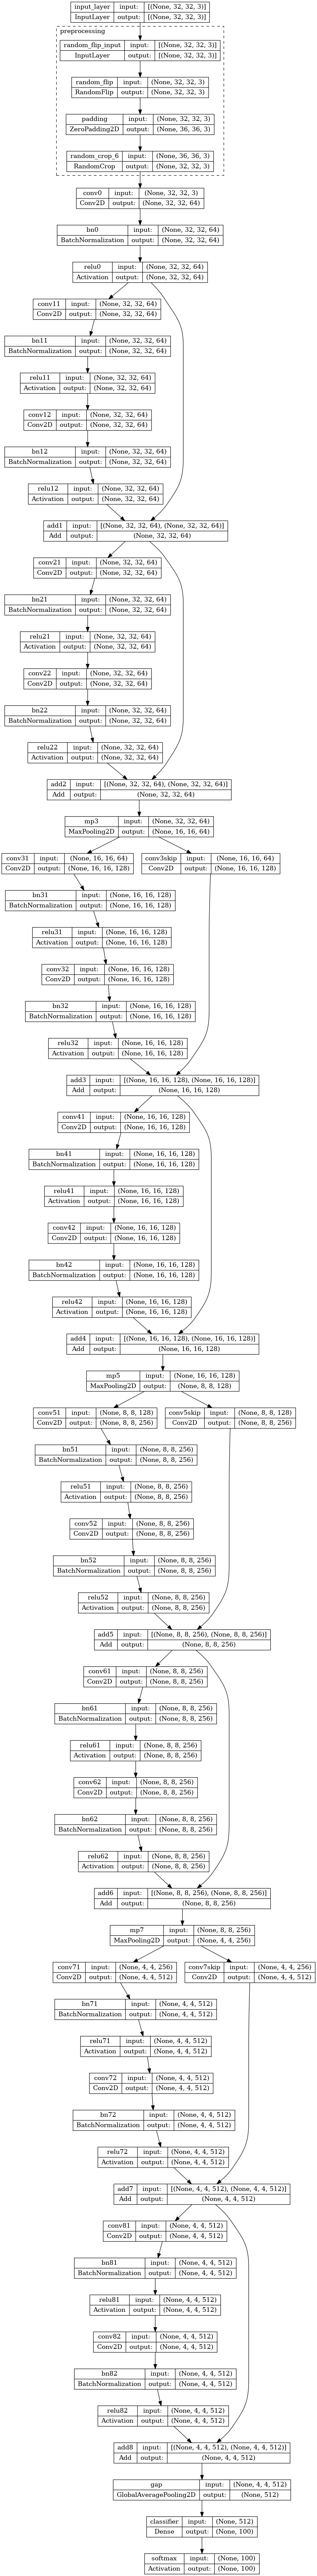

In [ ]:
residual_model = build_model_residual()
residual_model.summary()
tfk.utils.plot_model(residual_model, expand_nested=True, show_shapes=True)

In [ ]:
residual_history = residual_model.fit(
    X_train,
    y_train,
    validation_data=(X_val,y_val),
    epochs=epochs,
    batch_size=batch_size,
    verbose=1,
    callbacks=callbacks
).history

Epoch 1/1000
157/157 [==============================] - 28s 103ms/step - loss: 3.7096 - accuracy: 0.1645 - val_loss: 7.4561 - val_accuracy: 0.0107 - lr: 1.0000e-04
Epoch 2/1000
157/157 [==============================] - 15s 97ms/step - loss: 2.8954 - accuracy: 0.2838 - val_loss: 5.7602 - val_accuracy: 0.0255 - lr: 1.0000e-04
Epoch 3/1000
157/157 [==============================] - 15s 97ms/step - loss: 2.5413 - accuracy: 0.3509 - val_loss: 4.3876 - val_accuracy: 0.0965 - lr: 1.0000e-04
Epoch 4/1000
157/157 [==============================] - 15s 96ms/step - loss: 2.2797 - accuracy: 0.4062 - val_loss: 3.1476 - val_accuracy: 0.2419 - lr: 1.0000e-04
Epoch 5/1000
157/157 [==============================] - 15s 98ms/step - loss: 2.0737 - accuracy: 0.4520 - val_loss: 2.7184 - val_accuracy: 0.3200 - lr: 1.0000e-04
Epoch 6/1000
157/157 [==============================] - 15s 97ms/step - loss: 1.9127 - accuracy: 0.4870 - val_loss: 2.5418 - val_accuracy: 0.3524 - lr: 1.0000e-04
Epoch 7/1000
157/157 

Epoch 51/1000
157/157 [==============================] - 15s 96ms/step - loss: 0.1051 - accuracy: 0.9733 - val_loss: 2.6405 - val_accuracy: 0.4736 - lr: 1.0000e-04
Epoch 52/1000
157/157 [==============================] - 15s 98ms/step - loss: 0.0948 - accuracy: 0.9763 - val_loss: 2.7791 - val_accuracy: 0.4642 - lr: 1.0000e-04
Epoch 53/1000
157/157 [==============================] - 15s 98ms/step - loss: 0.0834 - accuracy: 0.9799 - val_loss: 2.6167 - val_accuracy: 0.4755 - lr: 1.0000e-04
Epoch 54/1000
157/157 [==============================] - 15s 97ms/step - loss: 0.0777 - accuracy: 0.9809 - val_loss: 2.5316 - val_accuracy: 0.4927 - lr: 1.0000e-04
Epoch 55/1000
157/157 [==============================] - 15s 96ms/step - loss: 0.0864 - accuracy: 0.9776 - val_loss: 2.6065 - val_accuracy: 0.4908 - lr: 1.0000e-04
Epoch 56/1000
157/157 [==============================] - 15s 97ms/step - loss: 0.0720 - accuracy: 0.9826 - val_loss: 2.5479 - val_accuracy: 0.4990 - lr: 1.0000e-04
Epoch 57/1000
15

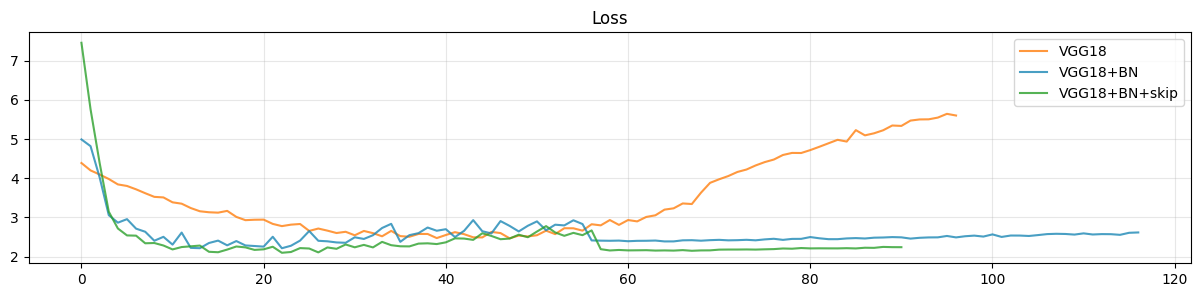

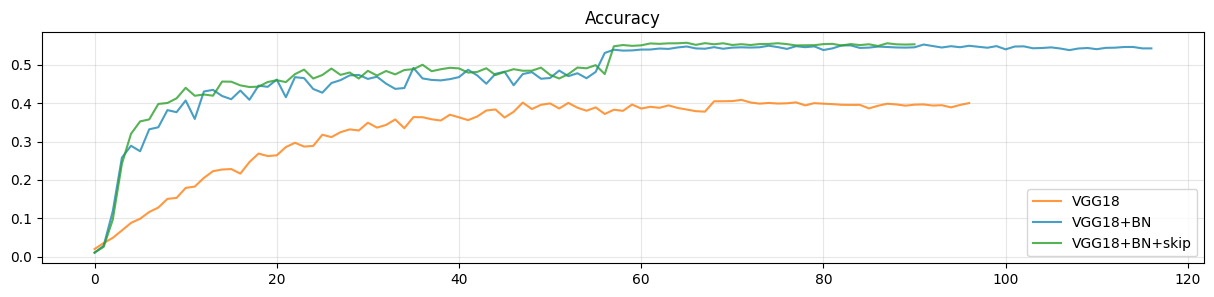

In [ ]:
# Plot validation loss for different models
plt.figure(figsize=(15, 3))
plt.plot(baseline_history['val_loss'], label='VGG18', alpha=0.8, color='#ff7f0e')
plt.plot(bn_history['val_loss'], label='VGG18+BN', alpha=0.8, color='#1B87B5')
plt.plot(residual_history['val_loss'], label='VGG18+BN+skip', alpha=0.8, color='#2ca02c')
plt.title('Validation Loss')
plt.legend()
plt.grid(alpha=0.3)

# Plot validation accuracy for different models
plt.figure(figsize=(15, 3))
plt.plot(baseline_history['val_accuracy'], label='VGG18', alpha=0.8, color='#ff7f0e')
plt.plot(bn_history['val_accuracy'], label='VGG18+BN', alpha=0.8, color='#1B87B5')
plt.plot(residual_history['val_accuracy'], label='VGG18+BN+skip', alpha=0.8, color='#2ca02c')
plt.title('Validation Accuracy')
plt.legend()
plt.grid(alpha=0.3)

# Show the plots
plt.show()

In [ ]:
residual_model.save('residual_model')
del residual_model

### Make inference

In [ ]:
# Load the saved residual model
residual_model = tfk.models.load_model('residual_model')

In [ ]:
# Predict labels for the entire test set
predictions = residual_model.predict(X_test, verbose=0)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)

Predictions Shape: (10000, 100)


Accuracy: 0.5685
Precision: 0.5823
Recall: 0.5685
F1: 0.5685


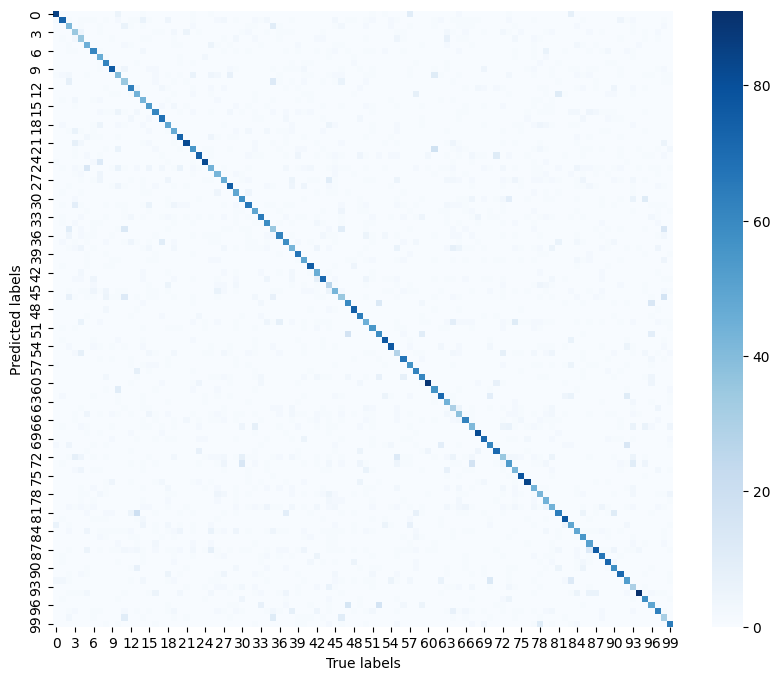

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

*Credits: Eugenio Lomurno, 📧 eugenio.lomurno@polimi.it*